In [2]:
from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.document_loaders import TextLoader
from langchain_ollama import OllamaEmbeddings
from pydantic import BaseModel,Field
from langchain.vectorstores import Chroma, FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [4]:
import os
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_aPI_KEY")

from langchain_ollama import OllamaEmbeddings
embeddings = OllamaEmbeddings(model="llama3.2:latest")

In [5]:
loader=TextLoader(file_path=r"C:\Users\ADMIN\OneDrive\Desktop\Git\END-TO_END_LANGGRAPH\END-TO_END_LANGGRAPH\indian_economic.txt")
docs = loader.load()
text_spliter = RecursiveCharacterTextSplitter(chunk_size=300,chunk_overlap=50)
new_doc = text_spliter.split_documents(documents=docs)

In [ ]:
db = Chroma.from_documents(new_doc, embeddings, persist_directory="./chroma_db")


In [23]:
retriver = db.as_retriever(search_kwargs={"k":3})

In [24]:
query = "what is llama3?"
docs = retriver.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)
print(docs)

for doc in docs:
    print(doc)

{'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}
Key Sector Performances:
[Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Key Sector Performances:'), Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Year\tGDP\n2022\t$3,517.24B\n2021\t$3,173.04B\n2020\t$2,935.57B\n2019\t$2,869.45B\n2018\t$2,715.50B\n2017\t$2,652.10B\n2016\t$2,479.15B\n2015\t$2,390.78B'), Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Additional Economic Indicators:')]
page_content='Key Sector Performances:' metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}
page_c

In [25]:
import operator
from typing import Sequence,Annotated,TypedDict
from langchain_core.messages import BaseMessage

In [26]:
class AgentState(TypedDict):
    message : Annotated[Sequence[BaseMessage],operator.add]

In [27]:
from pydantic import BaseModel,Field
from langchain_core.output_parsers import PydanticOutputParser

In [28]:
class parserpydantic(BaseModel):
    Topic : str = Field(discription="select topics")
    Reasoning : str = Field(discription="Resoning behind the topic")
    
parser = PydanticOutputParser(pydantic_object=parserpydantic)


In [29]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [30]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [31]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriver, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [32]:

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [33]:
# state = {"Message":["tell me about india"]}
# function_2(state)/

In [34]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()

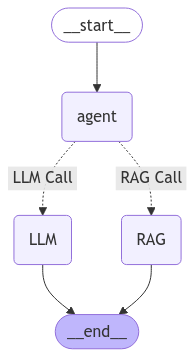

In [35]:
app5

In [40]:
state = {"messages": ["Tell me about USA Industrial Growth"]}

In [39]:
output = app5.invoke(inputs)

InvalidUpdateError: Must write to at least one of ['message']